In [2]:
import torch
torch.__version__

'1.8.1+cu102'

In [ ]:
!unzip T2ax-20210524T055444Z-001.zip

In [4]:
import os
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tqdm_notebook
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import torchvision.models as models
from torchvision import transforms

In [5]:
# Set to Your T2ax Photo Folder
data_dir = 'T2ax'
img_paths = glob(os.path.join(data_dir, '*'))
img_paths[0]

'T2ax/ProstateX-0104_1_T2ax_11_rot90.png'

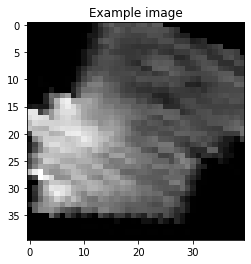

In [6]:
plt.imshow(Image.open(img_paths[1]), 'gray')
plt.title("Example image")
plt.show()

In [7]:
info_df = pd.DataFrame(img_paths, columns=['img_path'])
info_df['patientId'] = info_df['img_path'].apply(lambda x: x.split(os.sep)[-1].split('-')[1][:4])
info_df['label'] = info_df['img_path'].apply(lambda x: int(x.split(os.sep)[-1].split('_')[1]))
info_df.head()

,img_path,patientId,label
0,T2ax/ProstateX-0104_1_T2ax_11_rot90.png,0104,1
1,T2ax/ProstateX-0084_2_T2ax_3_rot70.png,0084,2
2,T2ax/ProstateX-0173_2_T2ax_13_rot45.png,0173,2
3,T2ax/ProstateX-0069_1_T2ax_12_rot5.png,0069,1
4,T2ax/ProstateX-0199_1_T2ax_8_rot45.png,0199,1


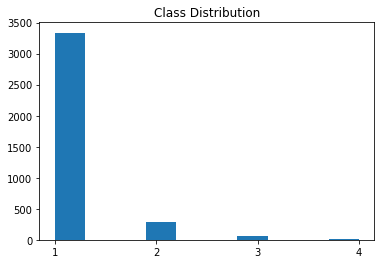

In [8]:
plt.hist(info_df['label'])
plt.title('Class Distribution')
plt.xticks([1., 2., 3., 4])
plt.show()

In [9]:
# split train, test dataset (0: train - 75%, 1: test - 25%)

for i in range(1, 4 + 1):
    info_df.loc[info_df['label'] == i, 'subset'] = [0] * round(sum(info_df['label'] == i) * 0.75) + [1] * round(sum(info_df['label'] == i) * 0.25)


In [10]:
info_df['patientId'].count()

3703

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [12]:
class PROSTATEx(Dataset):

    def __len__(self):
        return len(self.info_df)

    def __init__(self, info_df, subset):
        Dataset.__init__(self)
        self.info_df = info_df[info_df['subset'] == 0 if subset == 'train' else info_df['subset'] == 1]
        self._transform = transforms.ToTensor()

    def __getitem__(self, index):
        img_path = self.info_df.iloc[index].img_path
        label = self.info_df.iloc[index].label
        label = np.array([1, 0]) if label == 1 else np.array([0, 1])  # one-hot encoding  (aggresiveness low: 1, high: 2, 3, 4)

        # png -> numpy array -> tensor
        img_array = Image.open(img_path).convert('RGB')
        img_tensor = self._transform(img_array)

        return img_tensor, label


In [13]:
# Hyper-parameter Setting
num_classes = 2
epochs = 10
batch_size = 256
lr = 3e-5

In [14]:
# DataLoader Building
train_dataset = PROSTATEx(info_df, 'train')
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = PROSTATEx(info_df, 'test')
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
# Resnet Model Building
model = models.resnet50(num_classes=2).to(device)

In [16]:
# Optim
optimizer = optim.Adam(model.parameters(), lr=lr)

In [17]:
# Loss
criterion = nn.BCEWithLogitsLoss().to(device)

In [18]:
# Main

for epoch in range(1, epochs + 1):

    # Train
    # set torch model to train mode
    model.train()

    epoch_loss = 0
    epoch_correct_count = 0
    step = 0
    n_samples = 0

    for img, label in tqdm_notebook(train_data_loader, desc=f'Train [{epoch}/{epochs}]'):

        img, label = Variable(img).to(device).float(), Variable(label).to(device).float()

        # forward propagation with model
        predict = model(img)

        true_label = torch.max(label, 1)[1].data.cpu().numpy()
        pred_label = torch.max(predict, 1)[1].data.cpu().numpy()

        # count correct prediction
        epoch_correct_count += int(sum(true_label == pred_label))

        # calculate loss
        loss = criterion(predict, label)

        # backward propagation
        loss.backward()

        # parameter update with gradient
        optimizer.step()

        epoch_loss += loss * len(img)
        n_samples += len(img)

        # print loss every 5 step
        if step == 0 or (step + 1) % 5 == 0:
            print(
                f'    > Step [{step + 1:> 3}/{len(train_data_loader):> 3}] '
                f'Loss {epoch_loss / n_samples:.4f} '
                f'Accuracy {epoch_correct_count / n_samples * 100:.4f}%'
            )
            
        step += 1


    train_loss = epoch_loss / len(train_dataset)
    train_acc = epoch_correct_count / len(train_dataset) * 100

    # Test
    model.eval()

    epoch_loss = 0
    epoch_correct_count = 0

    # Prevent gradient calculation
    with torch.no_grad():

        for img, label in test_data_loader:

            img, label = Variable(img).to(device).float(), Variable(label).to(device).float()

            # prediction with model
            predict = model(img)

            true_label = torch.max(label, 1)[1].data.cpu().numpy()
            pred_label = torch.max(predict, 1)[1].data.cpu().numpy()

            # count correct prediction
            epoch_correct_count += int(sum(true_label == pred_label))

            # calculate loss
            loss = criterion(predict, label)

            epoch_loss += loss * len(img)

    test_loss = epoch_loss / len(test_dataset)
    test_acc = epoch_correct_count / len(test_dataset) * 100

    print(f">>> Train Result : Loss - {train_loss:.4f}, Accuracy - {train_acc:.2f}%")
    print(f">>> Test Result : Loss - {test_loss:.4f}, Accuracy - {test_acc:.2f}%")


    > Step [  1/ 11] Loss 0.7839 Accuracy 42.5781%
    > Step [  5/ 11] Loss 0.6944 Accuracy 70.3906%
    > Step [ 10/ 11] Loss 0.6045 Accuracy 79.8047%

>>> Train Result : Loss - 0.5898, Accuracy - 80.71%
>>> Test Result : Loss - 0.6591, Accuracy - 90.16%


    > Step [  1/ 11] Loss 0.3644 Accuracy 92.5781%
    > Step [  5/ 11] Loss 0.3559 Accuracy 90.7812%
    > Step [ 10/ 11] Loss 0.3473 Accuracy 90.2734%

>>> Train Result : Loss - 0.3508, Accuracy - 90.10%
>>> Test Result : Loss - 0.3384, Accuracy - 90.16%


    > Step [  1/ 11] Loss 0.3592 Accuracy 89.0625%
    > Step [  5/ 11] Loss 0.3368 Accuracy 90.1562%
    > Step [ 10/ 11] Loss 0.3587 Accuracy 90.1172%

>>> Train Result : Loss - 0.3608, Accuracy - 90.10%
>>> Test Result : Loss - 0.3781, Accuracy - 90.16%


    > Step [  1/ 11] Loss 0.3029 Accuracy 92.5781%
    > Step [  5/ 11] Loss 0.3695 Accuracy 91.0938%
    > Step [ 10/ 11] Loss 0.3944 Accuracy 90.5078%

>>> Train Result : Loss - 0.4142, Accuracy - 90.10%
>>> Test Result : Loss - 0.4103, Accuracy - 90.16%


    > Step [  1/ 11] Loss 0.4118 Accuracy 91.4062%
    > Step [  5/ 11] Loss 0.4120 Accuracy 90.3125%
    > Step [ 10/ 11] Loss 0.4020 Accuracy 89.8438%

>>> Train Result : Loss - 0.4006, Accuracy - 90.10%
>>> Test Result : Loss - 0.3530, Accuracy - 90.16%


    > Step [  1/ 11] Loss 0.3178 Accuracy 91.7969%
    > Step [  5/ 11] Loss 0.3974 Accuracy 89.4531%
    > Step [ 10/ 11] Loss 0.3849 Accuracy 90.2734%

>>> Train Result : Loss - 0.3828, Accuracy - 90.10%
>>> Test Result : Loss - 0.3778, Accuracy - 90.16%


    > Step [  1/ 11] Loss 0.3318 Accuracy 89.0625%
    > Step [  5/ 11] Loss 0.3517 Accuracy 89.6094%
    > Step [ 10/ 11] Loss 0.3382 Accuracy 89.9219%

>>> Train Result : Loss - 0.3346, Accuracy - 90.10%
>>> Test Result : Loss - 0.4981, Accuracy - 90.16%


    > Step [  1/ 11] Loss 0.3851 Accuracy 89.0625%
    > Step [  5/ 11] Loss 0.3497 Accuracy 90.2344%
    > Step [ 10/ 11] Loss 0.3463 Accuracy 90.0781%

>>> Train Result : Loss - 0.3457, Accuracy - 90.10%
>>> Test Result : Loss - 0.3763, Accuracy - 90.16%


    > Step [  1/ 11] Loss 0.3772 Accuracy 88.2812%
    > Step [  5/ 11] Loss 0.3281 Accuracy 90.3906%
    > Step [ 10/ 11] Loss 0.3315 Accuracy 90.1953%

>>> Train Result : Loss - 0.3337, Accuracy - 90.10%
>>> Test Result : Loss - 0.5923, Accuracy - 90.16%


    > Step [  1/ 11] Loss 0.2550 Accuracy 92.1875%
    > Step [  5/ 11] Loss 0.3115 Accuracy 90.1562%
    > Step [ 10/ 11] Loss 0.3046 Accuracy 90.4688%

>>> Train Result : Loss - 0.3124, Accuracy - 90.10%
>>> Test Result : Loss - 0.8539, Accuracy - 90.16%


In [20]:
!rm -rf T2ax